In [2]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:13 https://developer.download.nvidia.com/

In [3]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2021-11-23 06:26:44--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar.1’

postgresql-42.2.9.j 100%[===================>] 892.61K  1.50MB/s    in 0.6s    

2021-11-23 06:26:45 (1.50 MB/s) - ‘postgresql-42.2.9.jar.1’ saved [914037/914037]



In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [5]:
from pyspark import SparkFiles
# Load in csv from S3 into a DataFrame
url = "https://yelpproject4.s3.amazonaws.com/yelp_restaurants.csv"
spark.sparkContext.addFile(url)

df = spark.read.option('header', 'true').csv(SparkFiles.get("yelp_restaurants.csv"), inferSchema=True, sep=',', timestampFormat="mm/dd/yy")
df.show(10)

+--------------------+--------------------+--------------------+-----------+-----+-----------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------------+
|         business_id|                name|             address|       city|state|postal_code|     latitude|      longitude|stars|review_count|is_open|          attributes|          categories|               hours|
+--------------------+--------------------+--------------------+-----------+-----+-----------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------------+
|6iYb2HFDywm3zjuRg...| Oskar Blues Taproom|        921 Pearl St|    Boulder|   CO|      80302|   40.0175444|   -105.2833481|  4.0|          86|      1|"{'RestaurantsTab...| 'BikeParking': '...| 'BusinessParking...|
|tCbdrRPZA0oiIYSmH...|Flying Elephants ...| 7000 NE Airport Way|   Portland|   OR|      97218|45.5889058992|-122.5933307507|  4.0|         1

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [7]:
df1= df.select(["review_count","categories", "state", "stars"])

In [8]:
yelp = df1.toPandas()

In [9]:
yelp['stars']= yelp['stars'].astype(float)

In [11]:
def ycolumn(x):
  stars = x['stars']
  if stars >= 3:
    return 1
  else:
    return 0
yelp['Stars Y'] = yelp.apply(lambda x: ycolumn(x),axis=1)

In [15]:
X= yelp.drop(["stars", "Stars Y"], axis =1)

X

,review_count,categories,state
0,86,'BikeParking': 'True',CO
1,126,'GoodForKids': 'True',OR
2,169,'RestaurantsGoodForGroups': 'True',BC
3,11,"Breakfast & Brunch, Restaurants",OH
4,39,'intimate': False,MA
...,...,...,...
32017,733,"'WiFi': """"u'no'""""",MA
32018,437,"'RestaurantsAttire': """"'casual'""""",FL
32019,310,'street': False,TX
32020,185,'BusinessAcceptsCreditCards': 'True',GA


In [16]:
X_dummies = pd.get_dummies(X)
X_dummies

,review_count,categories_ 'AcceptsInsurance': 'True',"categories_ 'Alcohol': """"'beer_and_wine'""""","categories_ 'Alcohol': """"'full_bar'""""","categories_ 'Alcohol': """"'none'""""","categories_ 'Alcohol': """"u'beer_and_wine'""""","categories_ 'Alcohol': """"u'full_bar'""""","categories_ 'Alcohol': """"u'none'""""","categories_ 'Alcohol': """"u'none'""""}""","categories_ 'Ambience': """"{'hipster': False","categories_ 'Ambience': """"{'romantic': False","categories_ 'Ambience': """"{'touristy': False","categories_ 'Ambience': """"{'touristy': None","categories_ 'Ambience': """"{'touristy': True",categories_ 'Ambience': 'None',categories_ 'BYOB': 'False',categories_ 'BYOB': 'True',"categories_ 'BYOBCorkage': """"'no'""""","categories_ 'BYOBCorkage': """"'yes_corkage'""""","categories_ 'BYOBCorkage': """"'yes_free'""""","categories_ 'BestNights': """"{'monday': False","categories_ 'BestNights': """"{'monday': True",categories_ 'BikeParking': 'False',categories_ 'BikeParking': 'True',categories_ 'BusinessAcceptsBitcoin': 'False',categories_ 'BusinessAcceptsCreditCards': 'False',categories_ 'BusinessAcceptsCreditCards': 'True',"categories_ 'BusinessAcceptsCreditCards': 'True'}""","categories_ 'BusinessParking': """"{'garage': False","categories_ 'BusinessParking': """"{'garage': None","categories_ 'BusinessParking': """"{'garage': True","categories_ 'BusinessParking': """"{'valet': False",categories_ 'BusinessParking': 'None',categories_ 'ByAppointmentOnly': 'False',categories_ 'ByAppointmentOnly': 'True',categories_ 'Caters': 'False',"categories_ 'Caters': 'False'}""",categories_ 'Caters': 'True',"categories_ 'Caters': 'True'}""",categories_ 'CoatCheck': 'False',...,"categories_Vegetarian, Juice Bars & Smoothies, Vegan, Restaurants, Food, Latin American","categories_Vegetarian, Restaurants","categories_Vegetarian, Restaurants, Salad, Ice Cream & Frozen Yogurt, Food, Juice Bars & Smoothies, Fast Food","categories_Vegetarian, Vegan, Restaurants","categories_Vegetarian, Vegan, Salad, Restaurants","categories_Venues & Event Spaces, Chinese, Wedding Planning, Restaurants, Event Planning & Services","categories_Venues & Event Spaces, Cinema, Event Planning & Services, Arts & Entertainment, Restaurants, American (New)","categories_Venues & Event Spaces, Nightlife, Comfort Food, Hotels, Event Planning & Services, Restaurants, Bars, Hotels & Travel","categories_Venues & Event Spaces, Social Clubs, Arts & Entertainment, Restaurants, Event Planning & Services","categories_Vietnamese, Restaurants","categories_Vietnamese, Restaurants, Gluten-Free, Vegetarian","categories_Vietnamese, Soup, Restaurants, Noodles","categories_Waffles, Food, Bubble Tea, Hot Pot, Restaurants","categories_Waffles, Food, Cafes, Themed Cafes, Coffee & Tea, Restaurants","categories_Waffles, Food, Restaurants, Creperies, Acai Bowls","categories_Waffles, Taiwanese, Restaurants","categories_Wedding Planning, Event Planning & Services, Education, Restaurants, Social Clubs, Arts & Entertainment, American (New), Colleges & Universities, Venues & Event Spaces","categories_Wedding Planning, Event Planning & Services, Venues & Event Spaces, Caterers, Restaurants","categories_Wine Bars, Bars, Food, Bubble Tea, Restaurants, Nightlife, Steakhouses, Seafood, Asian Fusion","categories_Wine Bars, Nightlife, Cocktail Bars, Mexican, Bars, Vegan, Tacos, Restaurants","categories_Wine Bars, Pizza, Beer Bar, Bars, Restaurants, Nightlife","categories_Wine Tasting Room, Tapas/Small Plates, Nightlife, Restaurants, American (New), Wine Bars, Bars, Wineries, Food, Arts & Entertainment","categories_Wraps, Restaurants, Soup, Salad","categories_Wraps, Salad, Greek, Restaurants",state_ABE,state_BC,state_CO,state_FL,state_GA,state_KS,state_KY,state_MA,state_MN,state_NH,state_OH,state_OR,state_TX,state_VA,state_WA,state_WY
0,86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,126,0,

In [99]:
df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- is_open: integer (nullable = true)
 |-- attributes: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- hours: string (nullable = true)



In [17]:
# X = yelp.drop('is_open', axis=1)
y = yelp['Stars Y']
X=x
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
clf = RandomForestClassifier(random_state=1, n_estimators=100).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 0.9364173884077281
Testing Score: 0.7847864101923557


In [19]:
feature_importances = clf.feature_importances_

[0.24268299 0.00500817 0.00481464 ... 0.         0.00507816 0.00499943]


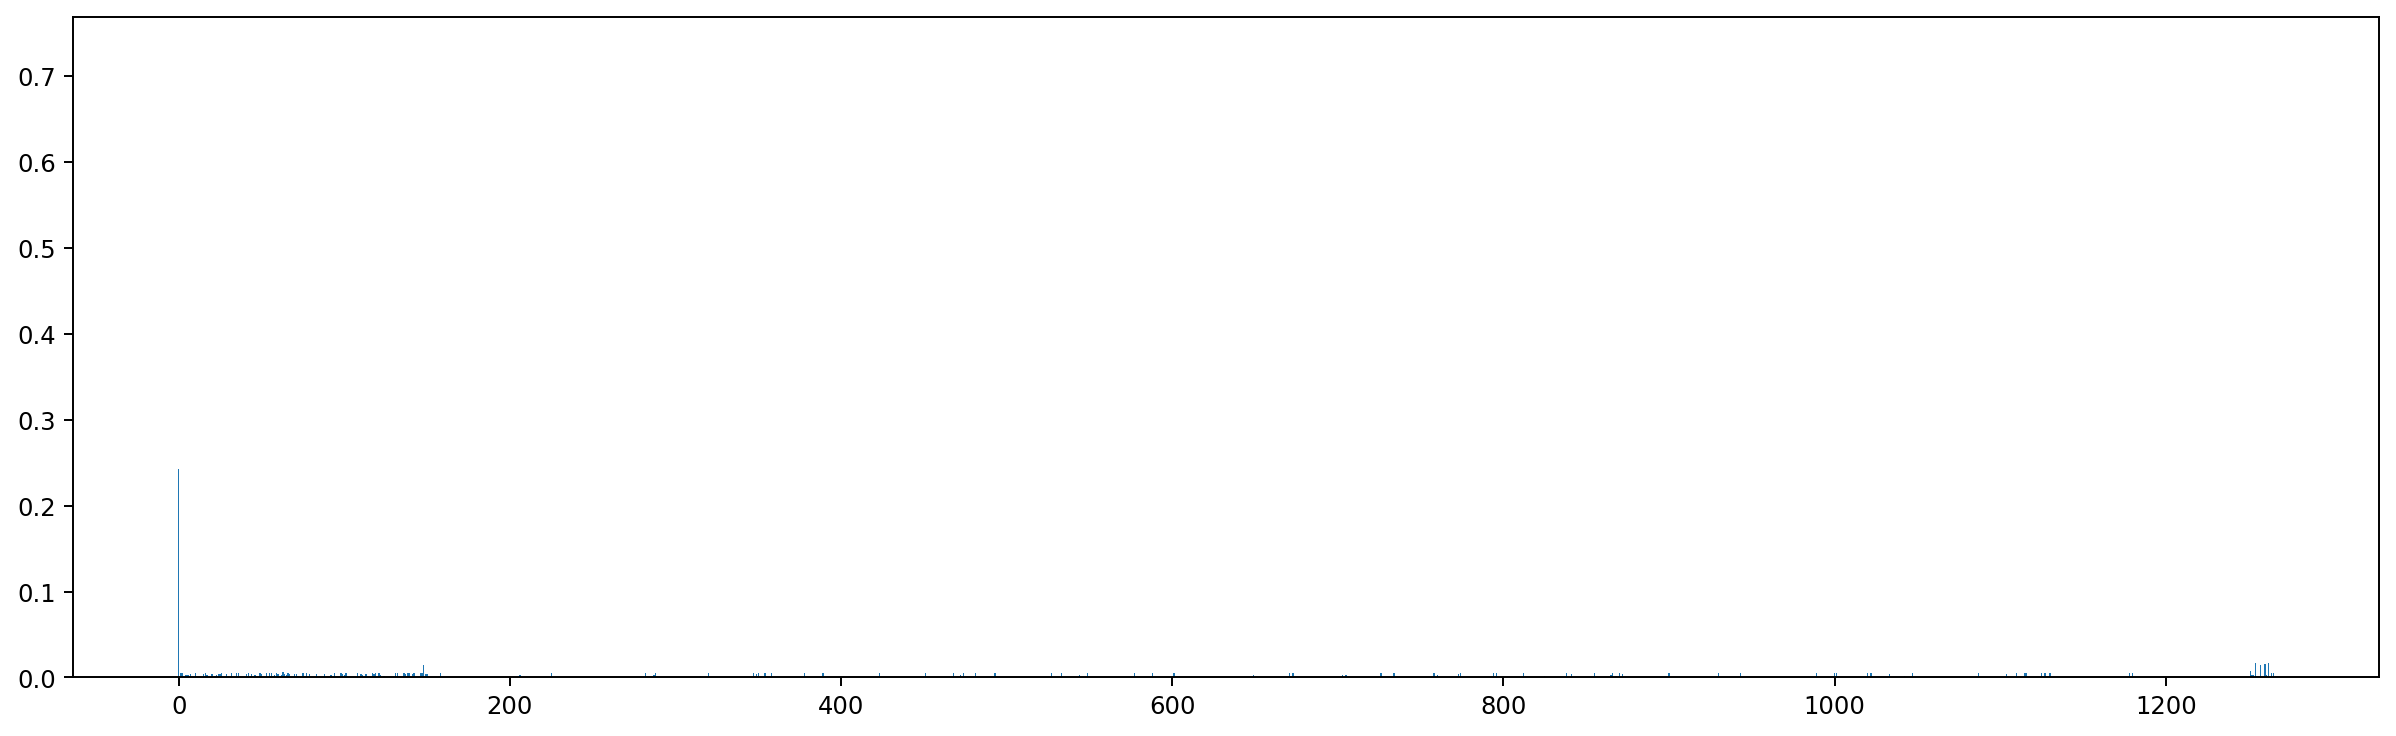

score: 0.7682987759180615


In [53]:
fig.set_size_inches(10,45)
plt.margins(y=0.001)
# plt.rcParams.update({'figure.figsize':(17,5), 'figure.dpi':175})
features = clf.feature_importances_
print(features)
plt.bar(x = range(len(features)), height=features)
score = accuracy_score(y_test, y_pred)
# score.append(score)
plt.plot(score)
plt.show()
print(f'score: {score}')


In [21]:
from sklearn.feature_selection import SelectFromModel

In [22]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(clf)
sel.fit(X_train_scaled, y_train)
sel.get_support()

array([ True, False, False, ..., False,  True, False])

In [23]:
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)
scaler = StandardScaler().fit(X_selected_train)
X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [24]:
# Import an Extremely Random Trees classifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
target_names = ["negative", "positive"]

In [25]:
clf = ExtraTreesClassifier(random_state=1).fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=target_names))
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

              precision    recall  f1-score   support

    negative       0.26      0.23      0.24      1288
    positive       0.86      0.87      0.86      6718

    accuracy                           0.77      8006
   macro avg       0.56      0.55      0.55      8006
weighted avg       0.76      0.77      0.76      8006

Training Score: 0.9365006662225184
Testing Score: 0.7682987759180615


In [26]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state=1, n_estimators=100, base_estimator=DecisionTreeClassifier(max_depth=2)).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 0.8437708194536976
Testing Score: 0.839120659505371
